### Synthetic Experiment Simulation

In [121]:
import numpy as np
from scipy import integrate
import itertools
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, TheilSenRegressor

def sim_exp(B1,B2,m,w,x,y,z,ips,icount,tmax = 120,timeseries = True):
    '''B1 and B2 are beta_s and beta_r respectively. m is mu, w,x,y,z are death game params.'''
    def dX_dt(X, t=0):
        """ Return the time derivatives.
        # X[0] is the number of sensitive cyan cells, X[1] is the number of resistant cyan cells.
        # X[2] is the number of sensitive magenta cells, X[3] is the number of resistant magenta cells.
        """
        return np.array([B1*(X[0] - m*X[0]) + B2*m*X[1] - (X[0]*(w*(X[0] + X[2]) + x*(X[1] + X[3])))/(X[0] + X[1] + X[2] + X[3]), 
                         B1*m*X[0] + B2*(X[1] - m*X[1]) - (X[1]*(y*(X[0] + X[2]) + z*(X[1] + X[3])))/(X[0] + X[1] + X[2] + X[3]), 
                         B1*(X[2] - m*X[2]) + B2*m*X[3] - (X[2]*(w*(X[0] + X[2]) + x*(X[1] + X[3])))/(X[0] + X[1] + X[2] + X[3]), 
                         B1*m*X[2] + B2*(X[3] - m*X[3]) - (X[3]*(y*(X[0] + X[2]) + z*(X[1] + X[3])))/(X[0] + X[1] + X[2] + X[3])])
    
    
    t = np.linspace(0, tmax, 1000)                          # time
    X0 = np.array([ips*icount,0,0,(1-ips)*icount])          # initials conditions
    X, infodict = integrate.odeint(dX_dt, X0, t, full_output=True)
    infodict['message'] 
    SC,RC,SM,RM = X.T
    RC[0] = RC[1];
    SM[0] = SM[1]; #Solves issues with taking logs later.
    
    SC2 = np.array([x if x>1/1000 else 1 for x in SC])
    RC2 = np.array([x if x>1/1000 else 1 for x in RC])
    SM2 = np.array([x if x>1/1000 else 1 for x in SM])
    RM2 = np.array([x if x>1/1000 else 1 for x in RM])
        
    
    if timeseries == True:
        
        f1 = plt.figure(figsize=(10, 10))
        plt.plot(t, np.log(SC2), 'c.', label='Sensitive Cyan Cells')
        plt.plot(t, np.log(RC2), 'c-', label='Resistant Cyan Cells')
        plt.plot(t, np.log(SM2), 'm.', label='Sensitive Magenta Cells')
        plt.plot(t, np.log(RM2), 'm-', label='Resistant Magenta Cells')
        plt.grid()
        plt.legend(loc='right')
        plt.xlabel('Time')
        plt.ylabel('Log Cell Count')
        plt.title('Assay Evolution with Small Mutation')
        plt.show()
        
        f2 = plt.figure(figsize=(10, 10))
        plt.plot(t, np.log(SC2+RC2), 'co', label='Cyan Cells')
        plt.plot(t, np.log(SM2+RM2), 'mo', label='Magenta Cells')
        plt.plot(t, np.log(SC2+SM2), 'r.', label='Sensitive Cells')
        plt.plot(t, np.log(RC2+RM2), 'g.', label='Resistant Cells')
        plt.grid()
        plt.legend(loc='right')
        plt.xlabel('Time')
        plt.ylabel('Log Cell Count')
        plt.title('Assay Evolution with Small Mutation')
        plt.show()
        
    return SC2[-800:],RC2[-800:],SM2[-800:],RM2[-800:],t[-800:]


def mutation_sweep_sim(B1,B2,w,x,y,z,steps):
    mutations = np.linspace(0, .001, steps) #realistic mutation rates.
    
    msrdx= np.zeros(steps)
    msrdy= np.zeros(steps)
    actualx= np.zeros(steps)
    actualy= np.zeros(steps)
        
    k=0;
    for mut in mutations:
        numic = 100;
        cutoff = 0.15; #Cutting off the ends.
        ips = np.linspace(cutoff, 1-cutoff, numic) 
        CY = np.zeros(numic)
        MG = np.zeros(numic)
        SS = np.zeros(numic)
        RE = np.zeros(numic)
        i = 0

        for ic in ips:
            SC,RC,SM,RM,t = sim_exp(B1,B2,mut,w,x,y,z,ic,1000,tmax = 120,timeseries=False);
            Cyan = Ridge(alpha=0.5).fit(t.reshape(-1, 1),np.log(SC+RC).reshape(-1, 1))
            CY[i] =Cyan.coef_
            Magenta = Ridge(alpha=0.5).fit(t.reshape(-1, 1),np.log(SM+RM).reshape(-1, 1))
            MG[i] =Magenta.coef_
            Sensitive = Ridge(alpha=0.5).fit(t.reshape(-1, 1),np.log(SC+SM).reshape(-1, 1))
            SS[i] =Sensitive.coef_
            Resistant = Ridge(alpha=0.5).fit(t.reshape(-1, 1),np.log(RC+RM).reshape(-1, 1))
            RE[i] =Resistant.coef_
            i = i+1


        ipplot= np.linspace(0, 1, 1000);

        ColorCY = TheilSenRegressor().fit(ips.reshape(-1, 1),CY.reshape(-1, 1).ravel())
        ColorCY.coef_
        cy =ColorCY.predict(ipplot.reshape(-1, 1));

        ColorMG = TheilSenRegressor().fit(ips.reshape(-1, 1),MG.reshape(-1, 1).ravel())
        ColorMG.coef_
        mg =ColorMG.predict(ipplot.reshape(-1, 1));

        TypeS = TheilSenRegressor().fit(ips.reshape(-1, 1),SS.reshape(-1, 1).ravel())
        TypeS.coef_
        ts =TypeS.predict(ipplot.reshape(-1, 1));

        TypeR = TheilSenRegressor().fit(ips.reshape(-1, 1),RE.reshape(-1, 1).ravel())
        TypeR.coef_
        tr =TypeR.predict(ipplot.reshape(-1, 1));

        COL =(cy-mg);
        RL = (ts-tr);
        
        msrdx[k]= -COL[-1]
        msrdy[k]= COL[0]
        actualx[k]= -RL[-1]
        actualy[k]= RL[0]
        k= k+1
        
    gspltrge = abs(1.2*max([max(msrdx,key=abs),max(msrdy,key=abs),max(actualx,key=abs),max(actualy,key=abs)],key = abs))
    plt.figure(figsize=(10, 10))
    plt.plot(msrdx,msrdy,'c',label='Measured')
    plt.plot(actualx,actualy,'m',label='Actual')
    plt.vlines(0,-1*gspltrge,gspltrge, linestyle="dashed")
    plt.hlines(0, -1*gspltrge, gspltrge, linestyle="dashed")
    plt.scatter(msrdx[0], msrdy[0], marker='o', color='green', zorder=2)
    plt.scatter(msrdx[-1], msrdy[-1], marker='x', color='red', zorder=2)
    plt.scatter(actualx[0],actualy[0], marker='o', color='green', zorder=2)
    plt.scatter(actualx[-1],actualy[-1], marker='x', color='red', zorder=2)
    plt.xlabel('Relative Fitness of Resistant Invader')
    plt.ylabel('Relative Fitness of Sensitive Invader')
    plt.title('Game Space')
    plt.legend(loc='upper left')
    plt.xlim([-1*gspltrge, gspltrge])
    plt.ylim([-1*gspltrge, gspltrge])
    plt.show()
    
    return


def quadrantwhich(x, y):
    if (x > 0 and y > 0):
        return 1
 
    elif (x < 0 and y > 0):
        return 2
         
    elif (x < 0 and y < 0):
        return 3
     
    elif (x > 0 and y < 0):
        return 4
         
    elif (x == 0 and y > 0):
        return 5
     
    elif (x == 0 and y < 0):
        return 6
     
    elif (y == 0 and x < 0):
        return 7
    
    elif (y == 0 and x > 0):
        return 8
    
    elif (y == 0 and x == 0):
        return 9
    
    
def quadrantcheck(x1,y1,x2,y2):
    return quadrantwhich(x1,y1) == quadrantwhich(x2,y2)

def angletransform(x):
    return np.multiply((-1*(np.sign(x)-1)/2),x+2*np.pi) + np.multiply((-1*(np.sign(-1*x)-1)/2),x)

def alpha_sweep_sim(a,b,c,d,am,bm,cm,dm,TMAX=120,plot=True):
    mut = 0.001;
    a1 = np.linspace(0, .01, 3)
    a2 = np.linspace(0, .01, 3)
    
    msrdx= np.zeros(9)
    msrdy= np.zeros(9)
    actualx= np.zeros(9)
    actualy= np.zeros(9)
    alphatracker = np.zeros((9,2))
        
    k=0;
    for a_s,a_r in itertools.product(a1, a2):
        alphatracker[k] = [a_s, a_r]
        numic = 20;
        cutoff = 0.15;
        ips = np.linspace(cutoff, 1-cutoff, numic) 
        CY = np.zeros(numic)
        MG = np.zeros(numic)
        SS = np.zeros(numic)
        RE = np.zeros(numic)
        i = 0
        
        w = a_s 
        x = a_s + a - b
        y = a_r + d - c
        z = a_r
        B1 = a_s + a
        B2 = a_r + d
        
        for ic in ips:
            SC,RC,SM,RM,t = sim_exp(B1,B2,mut,w,x,y,z,ic,1000,tmax = TMAX,timeseries=False);
            Cyan = Ridge(alpha=0.5).fit(t.reshape(-1, 1),np.log(SC+RC).reshape(-1, 1))
            CY[i] =Cyan.coef_
            Magenta = Ridge(alpha=0.5).fit(t.reshape(-1, 1),np.log(SM+RM).reshape(-1, 1))
            MG[i] =Magenta.coef_
            Sensitive = Ridge(alpha=0.5).fit(t.reshape(-1, 1),np.log(SC+SM).reshape(-1, 1))
            SS[i] =Sensitive.coef_
            Resistant = Ridge(alpha=0.5).fit(t.reshape(-1, 1),np.log(RC+RM).reshape(-1, 1))
            RE[i] =Resistant.coef_
            i += 1


        ipplot= np.linspace(0, 1, 5);

        ColorCY = TheilSenRegressor().fit(ips.reshape(-1, 1),CY.reshape(-1, 1).ravel())
        ColorCY.coef_
        cy =ColorCY.predict(ipplot.reshape(-1, 1));

        ColorMG = TheilSenRegressor().fit(ips.reshape(-1, 1),MG.reshape(-1, 1).ravel())
        ColorMG.coef_
        mg =ColorMG.predict(ipplot.reshape(-1, 1));

        TypeS = TheilSenRegressor().fit(ips.reshape(-1, 1),SS.reshape(-1, 1).ravel())
        TypeS.coef_
        ts =TypeS.predict(ipplot.reshape(-1, 1));

        TypeR = TheilSenRegressor().fit(ips.reshape(-1, 1),RE.reshape(-1, 1).ravel())
        TypeR.coef_
        tr =TypeR.predict(ipplot.reshape(-1, 1));

        COL = (cy-mg);
        RL  = (ts-tr);
        
        msrdx[k]= -COL[-1]
        msrdy[k]= COL[0]
        actualx[k]= -RL[-1]
        actualy[k]= RL[0]
        k= k+1
        
        plot2=0;
        if plot2:
            plt.figure(figsize=(10, 10))
            plt.plot(ipplot, cy, 'co', label='Cyan Cells')
            plt.plot(ipplot, mg, 'mo', label='Magenta Cells')
            plt.plot(ipplot, ts, 'r.', label='Sensitive Cells')
            plt.plot(ipplot, tr, 'g.', label='Resistant Cells')
            plt.plot(ips, CY, 'co')
            plt.plot(ips, MG, 'mo')
            plt.plot(ips, SS, 'r.')
            plt.plot(ips, RE, 'g.')
            plt.grid()
            plt.legend(loc='upper right')
            plt.xlabel('Initial Proportion of Sensitive Cells')
            plt.ylabel('Growth Rate')
            plt.title('Assay Evolution Growth Rates')
            plt.show()

    
    
    dist_err = [np.sqrt(((bm-dm)-actualy[tt])**2+((cm-am)-actualx[tt])**2)  for tt in range(9)]
    worst_case = np.argmax(dist_err)
    worst_dist = dist_err[worst_case]
    worst_params = alphatracker[worst_case]
    quad_err = [quadrantcheck((cm-am),(bm-dm),actualx[tt],actualy[tt])  for tt in range(9)]
    quad_error = np.mean(quad_err)
    
    direction = np.arctan2((actualx[worst_case]-msrdx[worst_case]),(actualy[worst_case]-msrdy[worst_case]))
    direction_to_actual_game = angletransform(direction)
    
    if plot:
        
        msrdx= [cm-am for tt in range(9)]
        msrdy= [bm-dm for tt in range(9)]
        
        gspltrge = abs(1.2*max([max(msrdx,key=abs),max(msrdy,key=abs),max(actualx,key=abs),max(actualy,key=abs)],key = abs))
        plt.figure(figsize=(10, 10))
        plt.vlines(0,-1*gspltrge,gspltrge, linestyle="dashed")
        plt.hlines(0, -1*gspltrge, gspltrge, linestyle="dashed")
        plt.scatter(msrdx, msrdy, marker='o', color='red', zorder=2)
        plt.scatter(actualx,actualy, marker='x', color='green', zorder=2)
        plt.xlabel('Relative Fitness of Resistant Invader')
        plt.ylabel('Relative Fitness of Sensitive Invader')
        plt.title('Game Space')
        plt.plot([(cm-am),actualx[worst_case]],[(bm-dm),actualy[worst_case]],'c',label='Worst Case Difference')
        plt.legend(loc='upper right')
        plt.xlim([-1*gspltrge, gspltrge])
        plt.ylim([-1*gspltrge, gspltrge])
        plt.show();
    
    return worst_dist, quad_error, worst_params, direction_to_actual_game, dist_err

def hold_msrd_constant(w,x,y,z,d_ca,d_bd,steps):
    a = np.zeros(steps)
    b = np.zeros(steps)
    c = np.zeros((steps,2))
    d = np.zeros(steps)
    dnorm = np.zeros(steps)

    k=0;
    d1 = d_ca; d2 = d_bd;
    
    for i in range(steps):
        a[k],b[k],c[k],d[k] = alpha_sweep_sim(w+k*d1,x+k*d2,y+k*d1,z+k*d2)
        dnorm[k] = np.sqrt(((w+k*d1)**2+(x+k*d2)**2+(y+k*d1)**2+(z+k*d2)**2))
        k+=1
    
    return a,b,c,d,dnorm


def Neighbourhood_Error(a,b,c,d,step,T,plot=False):
    '''Finds the worst error (difference between actual and measured game),
    and any quandrant errors, in a region around the measured game, varying the alphas as
    well as the measured game paramters. Mutation rate is assumed the plausible max of .001.
    Max error in measured params is about .01, and cap alphas at .1, likely conservative estimates.
    '''
    step_directions = [[i, j, k, l] for i in [0,-1,1] for j in [0,-1,1] for k in [0,-1,1] for l in [0,-1,1]];
    Errors = np.zeros(len(step_directions))
    QuadErrors = np.zeros(len(step_directions))
    index = 0
    for direc in step_directions:
        res = alpha_sweep_sim(a+step*direc[0],b+step*direc[1],c+step*direc[2],d+step*direc[3],a,b,c,d,TMAX=T,plot=plot)
        Errors[index] = res[0]
        QuadErrors[index] = res[1]
        index += 1
    return Errors, QuadErrors

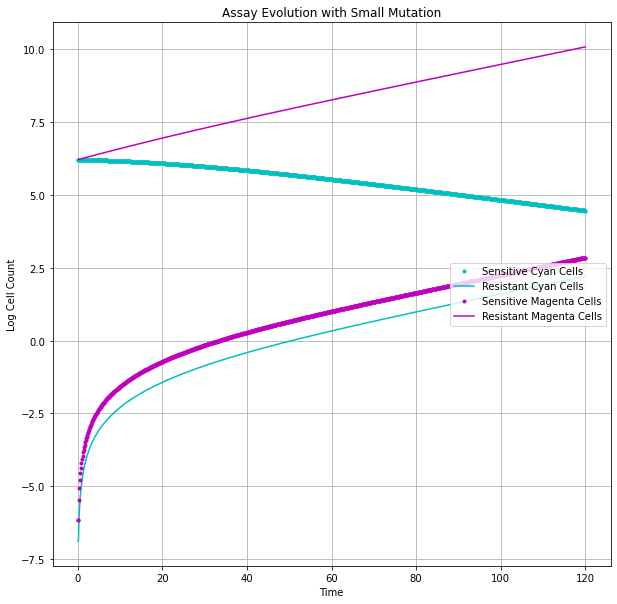

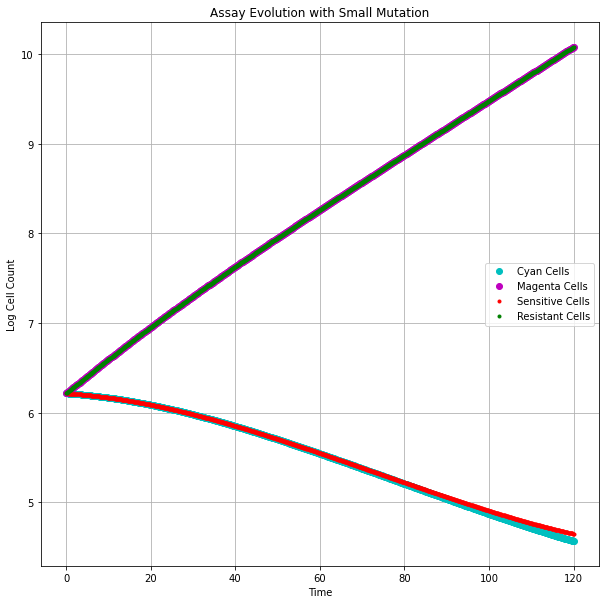

In [109]:
sim_exp(.017,.035,0.001,.005,.0127+.0228,.0304-.0431,.005,1/2,1000,tmax = 120,timeseries = True);

Holding a=.02 and d=.02, we let c and do go from -.02 to .06 in steps of 1.6, taking 36 measurements of neighbourhood error.

In [134]:
%%time
T = 5;
a = -0.02;
d = 0.01;
bvals = [d-.04 + k*.008 for k in range(11)];
cvals = [a-.04 + k*.008 for k in range(11)];

data = np.zeros((len(bvals)*len(cvals),5))
k=0;
for b,c in itertools.product(bvals, cvals):
    result1,result2 = Neighbourhood_Error(a,b,c,d,.002,T)
    data[k,0] = max(result1)
    data[k,1] = np.mean(result1)
    data[k,2] = 1 - np.mean(result2)
    data[k,3] = c - a
    data[k,4] = b - d
    k+=1
    if k%6==0:
        print('ETA: {} minutes, {}/121 complete'.format((121-k)*0.5,k))
    
#np.save('ap{}_dp{}_tmax{}_data_enhanced_HighRes'.format(a,d,T),data)

ETA: 57.5 minutes, 6/121 complete
ETA: 54.5 minutes, 12/121 complete
ETA: 51.5 minutes, 18/121 complete
ETA: 48.5 minutes, 24/121 complete
ETA: 45.5 minutes, 30/121 complete
ETA: 42.5 minutes, 36/121 complete
ETA: 39.5 minutes, 42/121 complete
ETA: 36.5 minutes, 48/121 complete
ETA: 33.5 minutes, 54/121 complete
ETA: 30.5 minutes, 60/121 complete
ETA: 27.5 minutes, 66/121 complete
ETA: 24.5 minutes, 72/121 complete
ETA: 21.5 minutes, 78/121 complete
ETA: 18.5 minutes, 84/121 complete
ETA: 15.5 minutes, 90/121 complete
ETA: 12.5 minutes, 96/121 complete
ETA: 9.5 minutes, 102/121 complete
ETA: 6.5 minutes, 108/121 complete
ETA: 3.5 minutes, 114/121 complete
ETA: 0.5 minutes, 120/121 complete
CPU times: user 52min 8s, sys: 8.56 s, total: 52min 17s
Wall time: 52min 20s


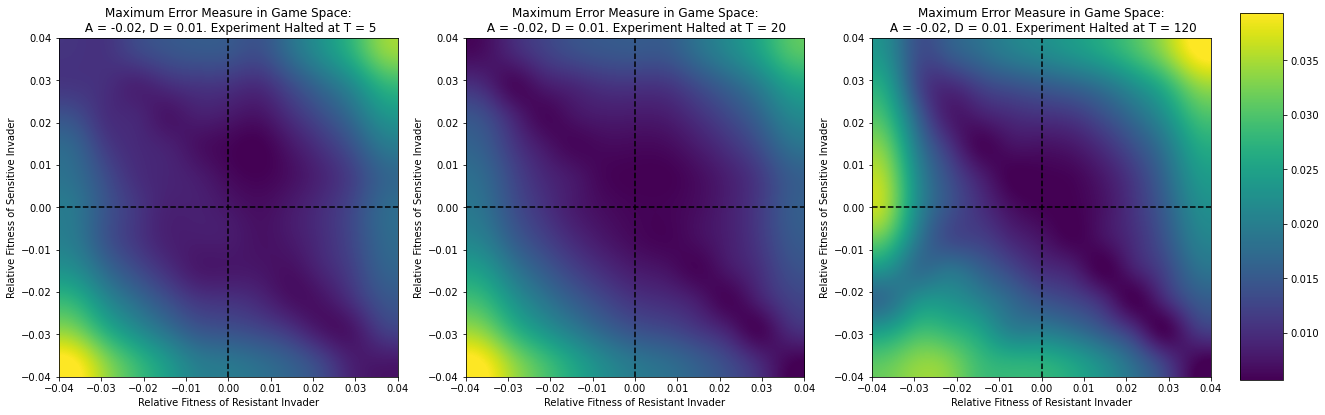

In [138]:
fixT1 = 5;
fixT2 = 20;
fixT3 = 120;
fixa = -0.02;
fixd = 0.01;
loaded_data1 = np.load('ap{}_dp{}_tmax{}_data_enhanced_HighRes.npy'.format(fixa,fixd,fixT1))
loaded_data2 = np.load('ap{}_dp{}_tmax{}_data_enhanced_HighRes.npy'.format(fixa,fixd,fixT2))
loaded_data3 = np.load('ap{}_dp{}_tmax{}_data_enhanced_HighRes.npy'.format(fixa,fixd,fixT3))

plot_ready_data1 = np.flipud(np.reshape(loaded_data1[:,0], (11, 11)))
plot_ready_data2 = np.flipud(np.reshape(loaded_data2[:,0], (11, 11)))
plot_ready_data3 = np.flipud(np.reshape(loaded_data3[:,0], (11, 11)))

f1 = plt.figure(figsize=(20, 6))

plt.subplot(131)
plt.imshow(plot_ready_data1,interpolation='spline36',extent=[-.04,.04,-.04,.04])
plt.vlines(0,-.04,.04, color='black', linestyle="dashed")
plt.hlines(0,-.04,.04, color='black', linestyle="dashed")
plt.xlabel('Relative Fitness of Resistant Invader')
plt.ylabel('Relative Fitness of Sensitive Invader')
plt.title('Maximum Error Measure in Game Space:\n A = {}, D = {}. Experiment Halted at T = {}'.format(fixa,fixd,fixT1))

plt.subplot(132)
plt.imshow(plot_ready_data2,interpolation='spline36',extent=[-.04,.04,-.04,.04])
plt.vlines(0,-.04,.04, color='black', linestyle="dashed")
plt.hlines(0,-.04,.04, color='black', linestyle="dashed")
plt.xlabel('Relative Fitness of Resistant Invader')
plt.ylabel('Relative Fitness of Sensitive Invader')
plt.title('Maximum Error Measure in Game Space:\n A = {}, D = {}. Experiment Halted at T = {}'.format(fixa,fixd,fixT2))

plt.subplot(133)
plt.imshow(plot_ready_data3,interpolation='spline36',extent=[-.04,.04,-.04,.04])
plt.vlines(0,-.04,.04, color='black', linestyle="dashed")
plt.hlines(0,-.04,.04, color='black', linestyle="dashed")
plt.xlabel('Relative Fitness of Resistant Invader')
plt.ylabel('Relative Fitness of Sensitive Invader')
plt.title('Maximum Error Measure in Game Space:\n A = {}, D = {}. Experiment Halted at T = {}'.format(fixa,fixd,fixT3))

plt.subplots_adjust(bottom=0.1, left=0.1, right=0.9, top=0.9)
cax = plt.axes([0.92, 0.1, .03, 0.85])
plt.colorbar(cax=cax)
plt.savefig('MAX_ALL_{}_{}.png'.format(fixa,fixd))
plt.show()